In [74]:
from collections import defaultdict
from itertools import product
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import yaml
from matplotlib import pyplot as plt
from scipy.stats import wilcoxon

PRED_PATH = Path().resolve() / "ax_runs" / "prediction"
STFS_PATH = Path().resolve() / "ax_runs" / "st_selection"
PLOT_PATH = Path().resolve() / "plots"

##### Plot 1: Regression performance

In [75]:
skip_methods = [
    # "jp_cb_stop",
    "jp_const_gb_part_l1",
    "jp_cb_dw",
    "cb_dw",
    "cb_drop",
    "jp_cb",
    "cb_bs",
]

In [76]:
# load regression results
reg_res = defaultdict(lambda: defaultdict(dict))

for task_type in PRED_PATH.iterdir():
    for method_dir in task_type.iterdir():
        if method_dir.is_dir():
            for dataset_dir in method_dir.iterdir():
                if dataset_dir.is_dir():
                    fp = dataset_dir / "metadata.yaml"

                    if not fp.exists() or method_dir.name in skip_methods:
                        continue

                    with open(fp, "r") as f:
                        reg_res[task_type.name][method_dir.name][dataset_dir.name] = (
                            yaml.safe_load(f)
                        )


reg_res = {k: dict(v) for k, v in reg_res.items()}

In [77]:
# only keep datasets shared by all methods
shared_datasets = defaultdict(lambda: defaultdict(set))

for task_type, methods in reg_res.items():
    for method, datasets in methods.items():
        # if len(datasets) in [10, 69]:
        #     continue

        for contains_categorical in [True, False, "postprocessed"]:
            keys = [
                k
                for k, v in datasets.items()
                if v["contains_categorical"] == contains_categorical
            ]

            if not shared_datasets[task_type][contains_categorical]:
                shared_datasets[task_type][contains_categorical] = set(keys)
            else:
                shared_datasets[task_type][contains_categorical] &= set(keys)

new_reg_res = defaultdict(lambda: defaultdict(dict))

for task_type, methods in reg_res.items():
    for method, datasets in methods.items():
        for contains_categorical in [True, False, "postprocessed"]:
            new_reg_res[task_type][method].update(
                {
                    k: v
                    for k, v in datasets.items()
                    if k in shared_datasets[task_type][contains_categorical]
                }
            )

reg_res = {k: dict(v) for k, v in new_reg_res.items()}

In [78]:
def plot_strip(
    reg_res: dict,
    colors: dict | None = None,
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    only_classification: bool = False,
    only_continuous: bool = False,
    figsize: tuple | None = None,
):
    """
    Create a strip plot based on the list of y-values.
    """
    x_values = []
    y_labels = []

    def score(vv: dict, only_classification: bool):
        # print(vv)
        if only_classification:
            return vv["metadata"]["test"]["zo_loss"]
        else:
            return vv["test_score"] / vv["dummy_loss"]

    rescaled_res = {
        k: {
            kk: score(vv, only_classification)
            for kk, vv in v.items()
            if not (
                only_continuous
                and vv["contains_categorical"] in [True, "postprocessed"]
            )
        }
        for k, v in reg_res.items()
    }

    rescaled_res = {k: v for k, v in rescaled_res.items() if len(v) > 0}

    median_res = {k: np.median(list(v.values())) for k, v in rescaled_res.items()}

    sorted_dict = {
        k: rescaled_res[k] for k in sorted(median_res, key=median_res.get)[::-1]
    }

    if colors is None:
        colors = [plt.cm.tab10(i) for i in range(len(sorted_dict))]
    else:
        colors = [plt.cm.tab20(colors[k]) for k in sorted_dict.keys()]

    for k, v in sorted_dict.items():
        x_values.append(v.values())
        y_labels.append(k)

    if figsize is None:
        figsize = (10, len(rescaled_res) * 2 / 3)

    fig, ax = plt.subplots(figsize=figsize, **plot_kwargs)

    for x_idx, val in enumerate(x_values):
        np.random.seed(random_state)
        # Apply jitter to x-axis positions
        y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in val]
        ax.scatter(val, y_values, c=[colors[x_idx]] * len(val), **scatter_kwargs)

    x_lim = (0, max(ax.get_xlim()[1], 1.2))
    x_lim = (0, min(x_lim[1], 1 if only_classification else 1.5))

    for x_idx, val in enumerate(x_values[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    # plot vertical line for median for each model
    medians = [np.median(list(val)) for val in x_values]
    for x_value, median in zip(range(len(x_values)), medians):
        ax.vlines(median, x_value - 1 / 2, x_value + 1 / 2, color="k")

    ax.set_xlim(x_lim)

    print({k: v for k, v in zip(y_labels, medians)})

    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)

    if not only_classification:
        ax.vlines(1, -1, len(y_labels) + 1, color="k", linestyle="--")

    ax.set_ylim(-1 / 2, len(y_labels) - 1 / 2)

    plt.xlabel("Normalized Loss" if not only_classification else "Zero-One Loss")

    plt.tight_layout()

    return ax, medians, len(list(rescaled_res.values())[0])


def compare_methods(reg_res1, reg_res2, is_classification):
    method1, method2 = [], []

    for k, v in reg_res1.items():
        if k in reg_res2:
            v2 = reg_res2[k]

            if is_classification:
                method1.append(v["metadata"]["test"]["zo_loss"])
                method2.append(v2["metadata"]["test"]["zo_loss"])
            else:
                method1.append(v["test_score"] / v["dummy_loss"])
                method2.append(v2["test_score"] / v2["dummy_loss"])

    return wilcoxon(method1, method2, alternative="less", method="exact").pvalue

In [79]:
p_vals = defaultdict(lambda: defaultdict(dict))
n_datasets = defaultdict(lambda: defaultdict(int))

for only_class, only_cont in product([True, False], [True, False]):
    pred_type = "class" if only_class else "regr"

    if pred_type not in reg_res:
        continue

    for method1, method2 in product(methods, repeat=2):
        if (
            method1 == method2
            or method1 not in reg_res[pred_type]
            or method2 not in reg_res[pred_type]
        ):
            continue

        valid_ds = [
            k
            for k, v in reg_res[pred_type][method1].items()
            if not (v["contains_categorical"] in [True, "postprocessed"] and only_cont)
        ]

        tmp = compare_methods(
            {k: v for k, v in reg_res[pred_type][method1].items() if k in valid_ds},
            {k: v for k, v in reg_res[pred_type][method2].items() if k in valid_ds},
            only_class,
        )

        p_vals[only_cont][pred_type][(method1, method2)] = tmp

p_vals = dict(p_vals)

/home/matt/code/school/joplen/code/joplen-tests/my_env311/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/matt/code/school/joplen/code/joplen-tests/my_env311/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [80]:
reg_res["regr"].keys()

dict_keys(['jp_const_rf_part', 'xgboost', 'rf_fr', 'jp_cb_stop', 'jp_const_gb_part_l2', 'cb', 'gb_fr', 'rf', 'gb'])

{'rf': 0.4718509271872403, 'rf_fr': 0.4525581655117397, 'xgboost': 0.39586168274089273, 'jp_const_rf_part': 0.38206574306477303, 'gb_fr': 0.37823545745025283, 'gb': 0.3637384433829179, 'cb': 0.33116067309836345, 'jp_const_gb_part_l2': 0.3117298027788973}


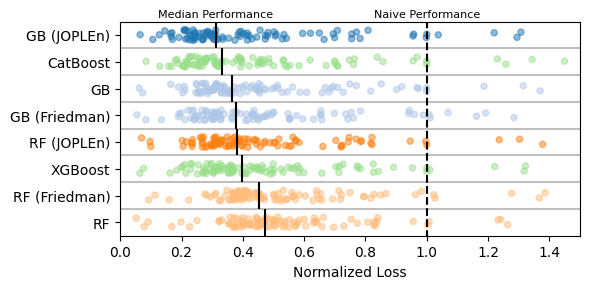

In [260]:
method_renamer = {
    "jp_const_rf_part": "RF (JOPLEn)",
    "xgboost": "XGBoost",
    "cb": "CatBoost",
    "rf_fr": "RF (Friedman)",
    "jp_const_gb_part_l2": "GB (JOPLEn)",
    "gb_fr": "GB (Friedman)",
    "rf": "RF",
    "gb": "GB",
}
colors = {
    "jp_const_rf_part": 2,
    "xgboost": 5,
    "cb": 5,
    "rf_fr": 3,
    "jp_const_gb_part_l2": 0,
    "gb_fr": 1,
    "rf": 3,
    "gb": 1,
}

filtered_res = {k: v for k, v in reg_res["regr"].items() if k in method_renamer}

ax, medians, _ = plot_strip(
    filtered_res,
    colors,
    scatter_kwargs={"alpha": 0.5, "s": 20},
    only_classification=False,
    only_continuous=False,
    figsize=(6, 3),
)

# annotate the smallest median
smallest_median = np.min(medians)
offset = len(medians) - 1 / 3
font_params = {
    "color": "black",
    "weight": "normal",
    "size": 8,
    "annotation_clip": False,
    "horizontalalignment": "center",
    "transform": ax.transAxes,
}

ax.annotate("Median Performance", xy=(smallest_median, offset), **font_params)

ax.annotate("Naive Performance", xy=(1, offset), **font_params)

sorted_labels = [v.get_text() for v in ax.get_yticklabels()]
ax.set_yticklabels([method_renamer[k] for k in sorted_labels])

plt.tight_layout()

plt.savefig(PLOT_PATH / "poster_reg_strip.pdf")

plt.show()

In [265]:
{k: v for k, v in p_vals[False]["regr"].items() if k[0] == "jp_const_gb_part_l2"}

{('jp_const_gb_part_l2', 'jp_const_rf_part'): 1.5016627730603287e-07,
 ('jp_const_gb_part_l2', 'xgboost'): 1.0240912211467752e-11,
 ('jp_const_gb_part_l2', 'rf_fr'): 1.1050909276750414e-13,
 ('jp_const_gb_part_l2', 'jp_cb_stop'): 2.516846061003821e-07,
 ('jp_const_gb_part_l2', 'cb'): 0.09931267089836102,
 ('jp_const_gb_part_l2', 'gb_fr'): 1.436088457632563e-05,
 ('jp_const_gb_part_l2', 'rf'): 2.4448514930923768e-12,
 ('jp_const_gb_part_l2', 'gb'): 1.2740263347103907e-09}

##### Figure 2: Feature selection

In [87]:
# load data

st_sel_res = defaultdict(lambda: defaultdict(list))

for method_dir in STFS_PATH.iterdir():
    if method_dir.is_dir():
        for dataset_dir in method_dir.iterdir():
            if dataset_dir.is_dir():
                metadata = defaultdict(list)
                for file in dataset_dir.iterdir():
                    if file.suffix == ".yaml":
                        with open(file, "r") as f:
                            file_content = yaml.safe_load(f)

                        density = file_content["model"]["results"]["density"]
                        metadata["density"].append(density)

                        test_err = file_content["model"]["score"]["norm_error"]["test"]
                        metadata["error"].append(test_err)

                st_sel_res[method_dir.name][dataset_dir.name] = dict(metadata)

for k, v in st_sel_res.items():
    st_sel_res[k] = dict(v)

st_sel_res = dict(st_sel_res)

In [88]:
def pareto_front(
    score: np.ndarray, density: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    unique_density = np.unique(density)

    pareto_score = []
    pareto_density = []

    for d in unique_density:
        mask = density == d
        pareto_score.append(np.min(score[mask]))
        pareto_density.append(d)

    pareto_score = np.array(pareto_score)
    pareto_density = np.array(pareto_density)

    args = np.argsort(pareto_density)

    return pareto_density[args], pareto_score[args]

/tmp/ipykernel_1484681/151113687.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


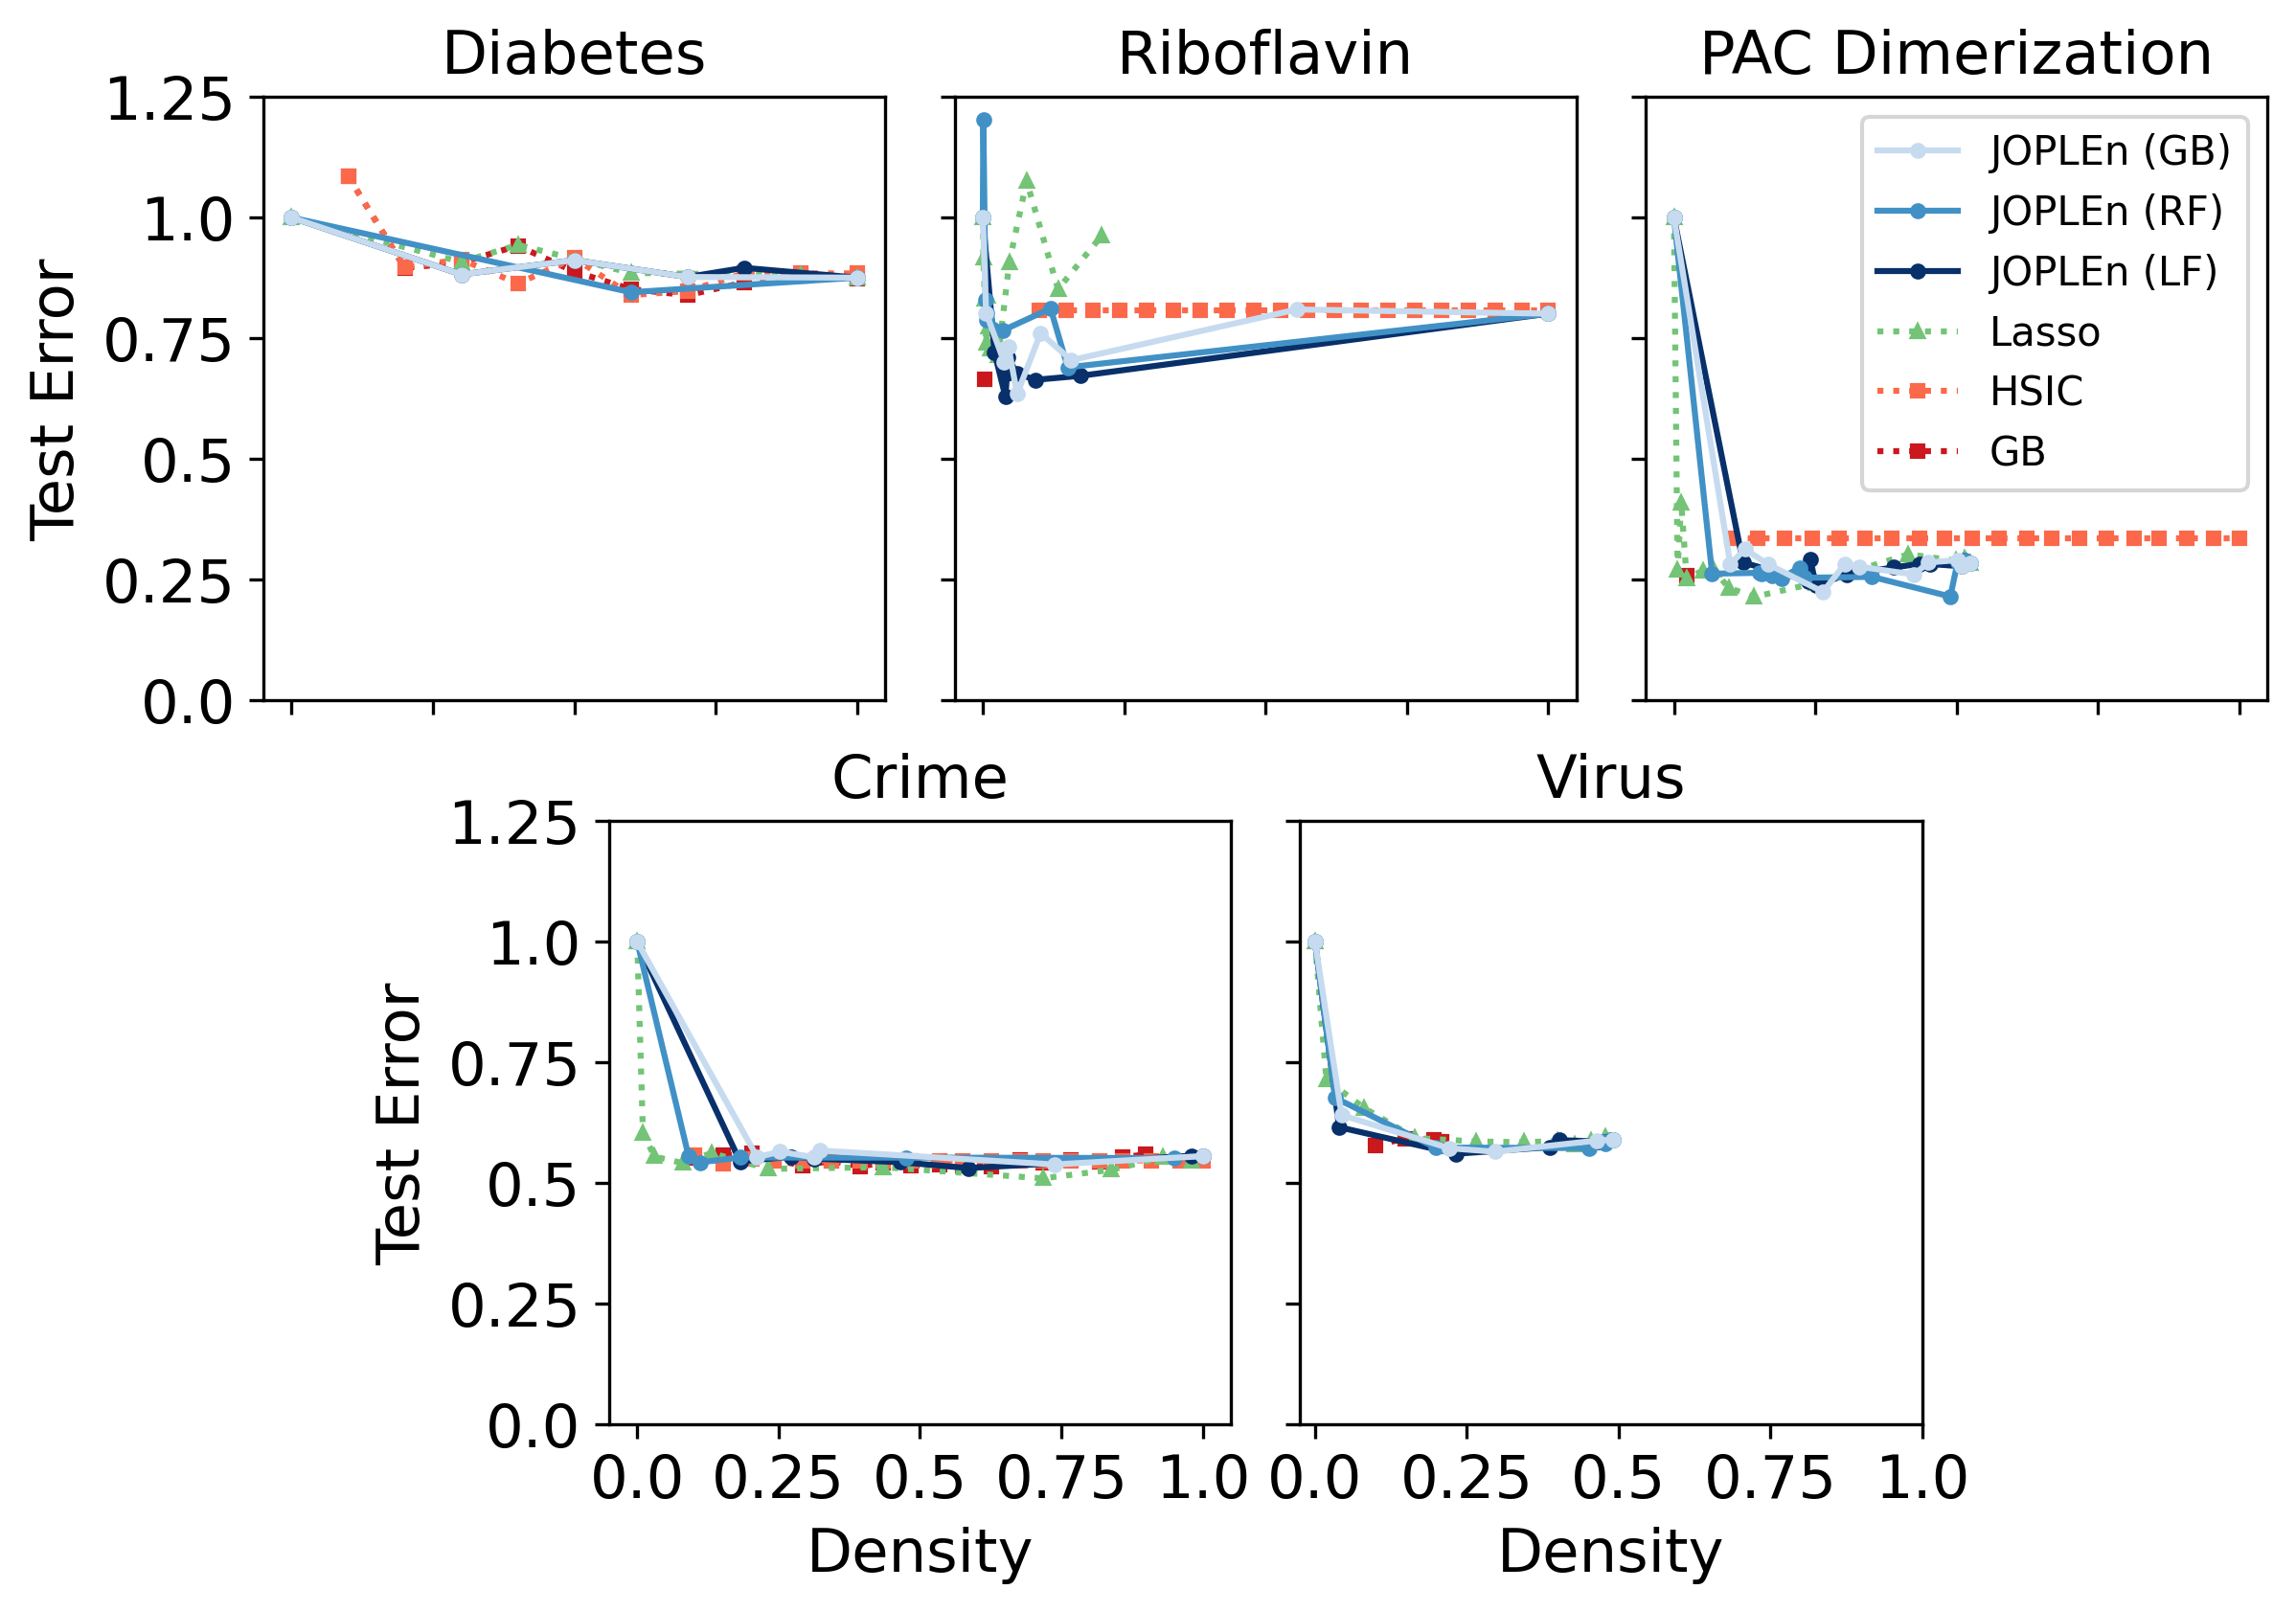

In [450]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

N_JOPLEN = 3
N_KERNEL = 1
N_ENSEMBLE = 2

# Generate colormaps
green_colormap = ListedColormap(
    cm.Blues(np.linspace(0.25, 1.0, N_JOPLEN))
)  # 4 shades of green
red_colormap = ListedColormap(
    cm.Greens(np.linspace(0.5, 0.75, N_KERNEL))
)  # 2 shades of red
blue_colormap = ListedColormap(
    cm.Reds(np.linspace(0.5, 0.75, N_ENSEMBLE))
)  # 2 shades of blue

LST_DATASETS = [
    # "boston", # leaving this out because of problematic input features
    "diabetes",
    "riboflavin",
    "pac_dimerization",
    "crime",
    "virus",
]

LST_METHODS = [
    # "jp_linear_mu",
    "jp_linear_gb_part",
    "jp_linear_rf_part",
    "jp_linear_linforest_part",
    # "jp_linear_inf",
    "lasso",
    "hsic",
    "gb",
    "rf",
    # "nn",
]

solid = LST_METHODS[:N_JOPLEN]

colors = [
    *green_colormap.colors,
    *red_colormap.colors,
    *blue_colormap.colors,
]

markers = [
    *(["o"] * N_JOPLEN),
    *(["^"] * N_KERNEL),
    *(["s"] * N_ENSEMBLE),
]

renamer = {
    "lasso": "Lasso",
    "gb": "GB",
    "rf": "RF",
    "hsic": "HSIC",
    # "jp_linear_mu": "JOPLEn (Voronoi)",
    "jp_linear_gb_part": "JOPLEn (GB)",
    "jp_linear_rf_part": "JOPLEn (RF)",
    # "jp_linear_inf": "JOPLEn (1, Inf)",
    "jp_linear_linforest_part": "JOPLEn (LF)",
    "nn": "Deep Feature Selection",
    "boston": "Boston Housing",
    "pac_dimerization": "PAC Dimerization",
}

font_size = 15


n_ds = len(LST_DATASETS)

# fig, axs = plt.subplots(
#     2,
#     int(np.ceil(n_ds / 2)),
#     figsize=(3 * np.ceil(n_ds / 2), 6),
#     sharey=True,
#     sharex=True,
#     dpi=300,
# )

from matplotlib.gridspec import GridSpec

fig = plt.figure(
    dpi=300,
    figsize=(9, 6),
)
gs = GridSpec(
    2,
    6,
    figure=fig,
    height_ratios=[1] * 2,
    width_ratios=[1] * 6,
    # hspace=0,
    wspace=0.25,
)

axs = [fig.add_subplot(gs[0, :2])]

axs.append(fig.add_subplot(gs[0, 2:4]))
axs.append(fig.add_subplot(gs[0, 4:6]))
axs.append(fig.add_subplot(gs[1, 1:3]))
axs.append(fig.add_subplot(gs[1, 3:5]))

# axs["B"]["left"] = fig.add_subplot(gs[2, :2])
# axs["B"]["right"] = fig.add_subplot(gs[2, 3], sharey=axs["B"]["left"])


zorder = 10

for ax, ds in zip(axs, LST_DATASETS):
    for i, (k, c, m) in enumerate(zip(LST_METHODS, colors, markers)):
        if ds not in st_sel_res[k]:
            continue

        model_score = np.array(st_sel_res[k][ds]["error"])
        model_density = np.array(st_sel_res[k][ds]["density"])

        pareto_density, pareto_score = pareto_front(model_score, model_density)
        ax.plot(
            pareto_density,
            pareto_score,
            label=renamer[k],
            marker=m,
            linestyle="-" if k in solid else ":",
            color=c,
            markersize=3,
            zorder=zorder - i,
        )

    ax.set_title(renamer.get(ds, ds.title()), fontsize=font_size)

for i in range(len(LST_DATASETS), len(axs)):
    axs[i].axis("off")

axs[2].legend()

# for ax in axs.:
axs[3].set_xlabel("Density", fontsize=font_size)
axs[4].set_xlabel("Density", fontsize=font_size)

# for ax in axs:
axs[0].set_ylabel("Test Error", fontsize=font_size)
axs[3].set_ylabel("Test Error", fontsize=font_size)

x_ticks = np.arange(0, 1.1, 0.25)
y_ticks = np.arange(0, 1.26, 0.25)

for ax in axs:
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, fontsize=font_size)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks, fontsize=font_size)

for ax in axs[:3]:
    ax.set_xticklabels([])

for ax in axs[1:3] + [axs[-1]]:
    ax.set_yticklabels([])

plt.tight_layout()

plt.savefig("plots/poster_feat_sel.pdf")
plt.show()

##### Singletask sparsity pattern

In [101]:
def scale_matrix(matrix, min_val, max_val):
    # Create an empty matrix of the same shape to store the scaled values
    scaled_matrix = np.zeros_like(matrix)

    assert min_val < 0 and max_val > 0, "min_val and max_val must have opposite signs"

    abs_max = max(abs(min_val), abs(max_val))

    # Handle negative and zero values
    neg_mask = matrix <= 0
    scaled_matrix[neg_mask] = matrix[neg_mask] / abs_max

    # Handle positive values
    pos_mask = matrix > 0
    scaled_matrix[pos_mask] = matrix[pos_mask] / abs_max

    return scaled_matrix


def plot_joplen_weights(weights, transpose=False, figsize=(5, 5)):
    n_feats, n_cells = weights.shape
    weights = weights

    weights = scale_matrix(weights, weights.min(), weights.max())

    fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=True, sharex=True, dpi=300)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    if not transpose:
        ax.matshow(weights, **params)
        ax.set_xlabel("Partitions and cells")
        ax.set_ylabel("Features")
    else:
        ax.matshow(weights.T, **params)
        ax.set_xlabel("Features")
        ax.set_ylabel("Partitions and cells")

    plt.tight_layout()
    return fig, ax

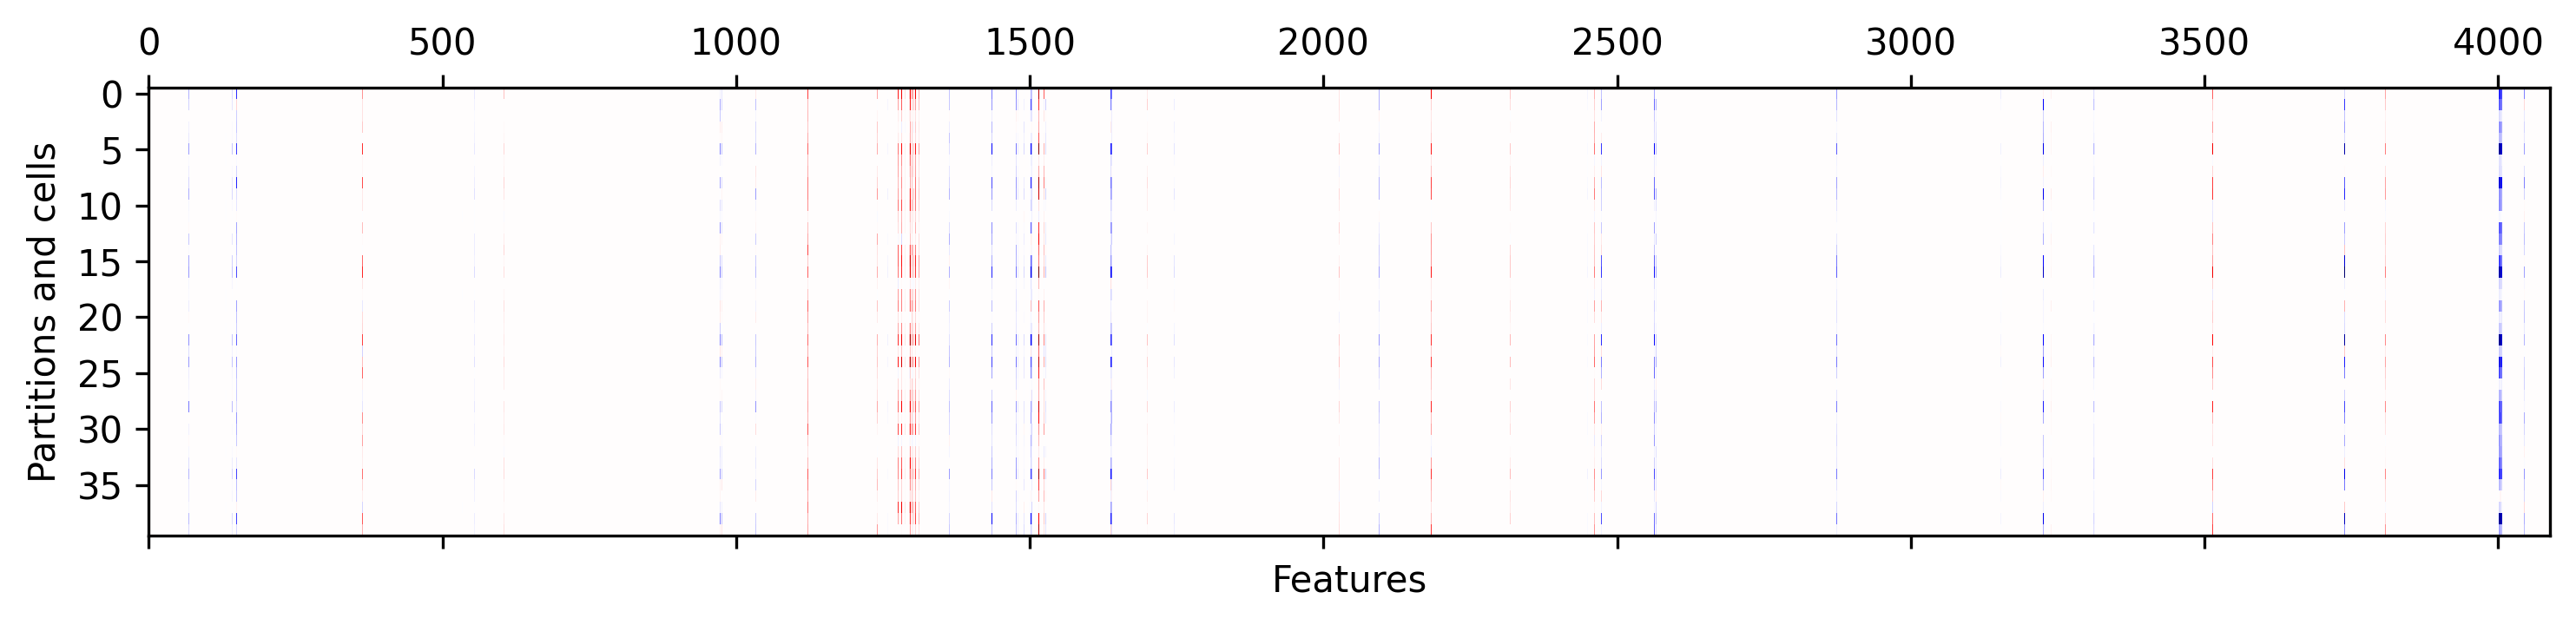

In [102]:
misc_data_path = Path() / "misc_data"

riboflavin_weights = np.loadtxt(
    misc_data_path / "riboflavin_weights.csv",
    delimiter=",",
)

_, ax = plot_joplen_weights(riboflavin_weights, True, (10, 2.5))

plt.savefig("plots/fig3.pdf", bbox_inches="tight")
plt.show()

##### Multitask sparsity pattern

In [421]:
import matplotlib as mpl


def plot_joplen_weights(core_weights, task_weights, axs=None):
    min_val = min(core_weights.min(), task_weights.min())
    max_val = max(core_weights.max(), task_weights.max())

    n_tasks, n_feats, n_cells = core_weights.shape
    core_weights = core_weights.transpose(1, 0, 2).reshape(n_feats, -1)
    task_weights = task_weights.transpose(1, 0, 2).reshape(n_feats, -1)

    core_weights = scale_matrix(core_weights, min_val, max_val)
    task_weights = scale_matrix(task_weights, min_val, max_val)

    # make the background white
    core_weights[core_weights == 0] = np.nan
    task_weights[task_weights == 0] = np.nan

    if axs is None:
        fig, axs = plt.subplots(2, 1, figsize=(8, 3), sharey=True, sharex=True)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    axs[0].matshow(core_weights, **params)
    # axs[0].set_title("Common weights")
    axs[1].matshow(task_weights, **params)
    # axs[1].set_title("Task-specific weights")

    # create a vertical line between each task
    for ax in axs:
        for i in range(n_tasks - 1):
            ax.axvline((i + 1) * n_cells, color="k", linewidth=1, alpha=0.25)

    # axs[1].set_xticks(np.arange(n_tasks) * n_cells + n_cells / 2)
    # axs[1].set_xticklabels([f"Task {i + 1}" for i in range(n_tasks)])

    axs2 = axs[0].twiny()
    axs2.spines["bottom"].set_position(("axes", 1.1))
    axs2.tick_params("both", length=0, width=0, which="minor")
    axs2.tick_params("both", direction="in", which="major")
    axs2.xaxis.set_ticks_position("bottom")
    axs2.tick_params(direction="out", axis="x")
    ticks = np.arange(n_tasks + 1) * n_cells
    axs2.set_xticks(ticks)
    axs2.set_xticklabels([])
    halfway_points = (ticks[1:] + ticks[:-1]) / 2
    axs2.xaxis.set_minor_locator(plt.FixedLocator(halfway_points))
    axs2.xaxis.set_minor_formatter(
        plt.FuncFormatter(lambda x, _: f"Task {int(x / n_cells + 1)}")
    )
    axs2.tick_params(axis="x", which="minor", pad=-15)  # Increase pad for more offse

    for ax in axs:
        ax.set_xticks([])

    # for ax in axs:
    #     ax.set_ylabel("Features")
    axs[0].set_ylabel("Common ($\\mathbf{B}$)")
    axs[1].set_ylabel("Task-specific ($\\mathbf{A}$)")

    axs[1].set_xlabel("Index of weights")

    plt.tight_layout()

    return ax

In [314]:
import pandas as pd

OUT_PATH = Path() / "experiments" / "manual" / "multitask"


# load data
def load_results(dataset):
    path = OUT_PATH / dataset

    # prediction performance
    jp_res = pd.read_csv(path / "joplen.csv", index_col=0)
    dl_res = pd.read_csv(path / "dl.csv", index_col=0)
    dummy_results = pd.read_csv(path / "dummy.csv", index_col=0)
    linear_results = pd.read_csv(path / "linear.csv", index_col=0)
    gb_results = pd.read_csv(path / "gb.csv", index_col=0)

    # weights
    jp_path = path / "joplen"
    jp_core = np.load(jp_path / "core.npy")
    jp_task = np.load(jp_path / "task.npy")

    dl_path = path / "dirty_lasso"
    dl_core = np.load(dl_path / "core.npy")
    dl_task = np.load(dl_path / "task.npy")

    return (
        jp_res,
        dl_res,
        dummy_results,
        linear_results,
        gb_results,
        jp_core,
        jp_task,
        dl_core,
        dl_task,
    )

In [315]:
res = load_results("sarcos")
(
    sarcos_jp_res,
    sarcos_dl_res,
    sarcos_dummy_results,
    sarcos_linear_results,
    sarcos_gb_results,
    sarcos_jp_core,
    sarcos_jp_task,
    sarcos_dl_core,
    sarcos_dl_task,
) = res

res = load_results("parkinsons")
(
    park_jp_res,
    park_dl_res,
    park_dummy_results,
    park_linear_results,
    park_gb_results,
    park_jp_core,
    park_jp_task,
    park_dl_core,
    park_dl_task,
) = res

res = load_results("nanoparticle")
(
    nano_jp_res,
    nano_dl_res,
    nano_dummy_results,
    nano_linear_results,
    nano_gb_results,
    nano_jp_core,
    nano_jp_task,
    nano_dl_core,
    nano_dl_task,
) = res

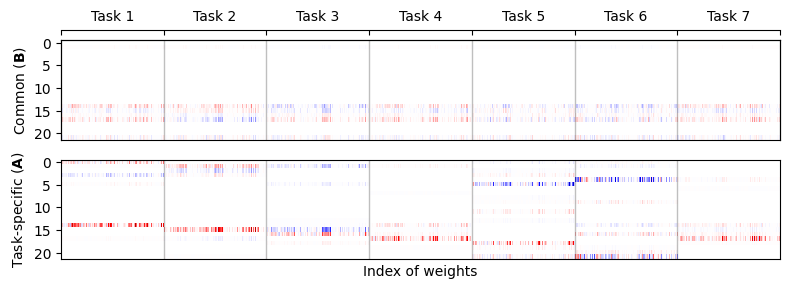

In [422]:
ax = plot_joplen_weights(sarcos_jp_core, sarcos_jp_task)

plt.savefig("plots/poster_fig4.pdf", bbox_inches="tight")

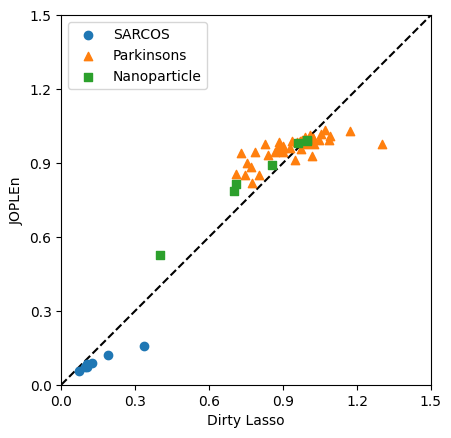

In [317]:
plt.scatter(
    sarcos_dl_res["test"] / sarcos_dummy_results["test"],
    sarcos_jp_res["test"] / sarcos_dummy_results["test"],
    label="SARCOS",
    marker="o",
    zorder=10,
)

plt.scatter(
    park_dl_res["test"] / park_dummy_results["test"],
    park_jp_res["test"] / park_dummy_results["test"],
    label="Parkinsons",
    marker="^",
    zorder=10,
)

plt.scatter(
    nano_dl_res["test"] / nano_dummy_results["test"],
    nano_jp_res["test"] / nano_dummy_results["test"],
    label="Nanoparticle",
    marker="s",
    zorder=10,
)

x = np.linspace(0, 1.5, 6, endpoint=True)

plt.plot(x, x, color="k", linestyle="--", zorder=0)

plt.xticks(x)
plt.yticks(x)

plt.xlabel("Dirty Lasso")
plt.ylabel("JOPLEn")
plt.legend()
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)

plt.gca().set_aspect("equal")

plt.show()

In [318]:
! pip install git+https://github.com/jhultman/matplotlib-curly-brace

  Cloning https://github.com/jhultman/matplotlib-curly-brace to /tmp/pip-req-build-d6f3crxu
  Running command git clone --filter=blob:none --quiet https://github.com/jhultman/matplotlib-curly-brace /tmp/pip-req-build-d6f3crxu
  Resolved https://github.com/jhultman/matplotlib-curly-brace to commit 2a757496756080ca683f618d3afdd480dd814989
  Preparing metadata (setup.py) ... done


1.0
-1.0
0.5


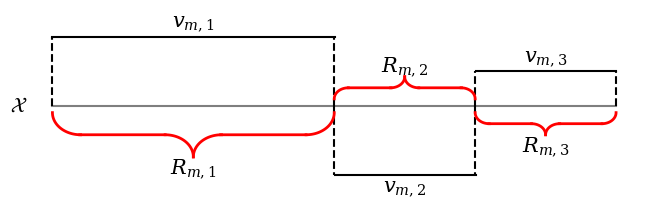

In [319]:
from curlyBrace import curlyBrace
from matplotlib import rc_context

fig, axs = plt.subplots(1, 1, figsize=(8, 2.5), sharey=True, sharex=True)

x = np.linspace(-1, 1, endpoint=True, num=1000)

cutoffs = np.array([-1, 0, 1 / 2, 1])
values = np.array([1, -1, 1 / 2])
directions = ["up", "down", "up"]

axs.plot([-1, 1], [0, 0], color="k", alpha=0.5)

for i in range(1, len(cutoffs)):
    offset = x[1] - x[0]
    x_vals = x[(x >= cutoffs[i - 1]) & (x - offset <= cutoffs[i])]
    y_vals = np.full_like(x_vals, values[i - 1])

    axs.plot(x_vals, y_vals, color="k")

    bounds = [cutoffs[i - 1], cutoffs[i]]
    axs.vlines(bounds, 0, values[i - 1], color="k", linestyle="--")

font_dict = {
    "color": "k",
    "family": "serif",
    "size": 15,
}

with rc_context({"mathtext.fontset": "dejavuserif"}):
    for i, (start, end, direction) in enumerate(
        zip(cutoffs[:-1], cutoffs[1:], directions)
    ):
        offset = 0.1
        scale = 0.1

        signed_offset = -offset if direction == "up" else offset

        if direction == "up":
            p1 = (start, signed_offset)
            p2 = (end, signed_offset)
        else:
            p1 = (end, signed_offset)
            p2 = (start, signed_offset)

        curlyBrace(
            fig=fig,
            ax=axs,
            p2=p1,
            p1=p2,
            k_r=scale,
            str_text="$R_{m," + str(i + 1) + "}$",
            color="r",
            lw=2,
            int_line_num=1,
            fontdict=font_dict,
        )

        center = (start + end) / 2
        axs.annotate(
            "$v_{m," + str(i + 1) + "}$",
            (center, values[i] - 2 * signed_offset),
            ha="center",
            va="center",
            **font_dict,
        )
        print(values[i])

    offset = 1 / 10
    axs.set_ylim(-1 - 4 * offset, 1 + 4 * offset)

    axs.set_xticks([])
    axs.set_yticks([])
    axs.spines[["right", "top", "left", "bottom"]].set_visible(False)
    axs.set_ylabel(
        "$\mathcal{X}$",
        rotation=0,
        va="center",
        **font_dict,
    )

plt.savefig("plots/poster_tree_diagram.pdf", bbox_inches="tight")

plt.show()